In [24]:
# Import necessary libraries
from graph import ZoneTransformer, build_transition_graph
from kloppy import wyscout
from kloppy.domain import Orientation

zt = ZoneTransformer()

match_id = 2058017
data = wyscout.load_open_data(match_id)
home_team, away_team = data.metadata.teams
home_team_id, away_team_id = int(home_team.team_id), int(away_team.team_id)

data = data.transform(
    Orientation.ACTION_EXECUTING_TEAM
) 
df_raw = data.to_df(*zt.INCLUDE_COLS, engine="pandas")
df_raw.set_index("event_id", inplace=True)
df_raw = zt.transform(df_raw)

INCLUDE_EVENTS = ["PASS", "SHOT", "DUEL", "GOALKEEPER"]
df = df_raw[df_raw["event_type"].isin(INCLUDE_EVENTS)]
df_home = df[df["team_id"] == home_team_id]

G_home = build_transition_graph(df_home)

print("Number of nodes:", G_home.number_of_nodes())
print("Number of edges:", G_home.number_of_edges())
print(G_home)

if 40 in G_home.nodes():
    G_home.remove_node(40)
    print("Removed node 40")
else:
    print("Node 40 not found")

Number of nodes: 38
Number of edges: 194
DiGraph with 38 nodes and 194 edges
Removed node 40


In [25]:
# Import necessary libraries
from graph import ZoneTransformer, build_transition_graph
from kloppy import wyscout
from kloppy.domain import Orientation
import numpy as np
import matplotlib.pyplot as plt
from node2vec import Node2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd


# ============================================================================
# 2. TRAIN NODE2VEC
# ============================================================================

print("\n" + "="*70)
print("TRAINING NODE2VEC")
print("="*70)

# Initialize Node2Vec
# NOTE: Using workers=1 to avoid pickling issues with multiprocessing
# If you want parallel processing, you may need to restructure the code
node2vec = Node2Vec(
    G_home,
    dimensions=64,        # Embedding size
    walk_length=30,       # Length of random walks
    num_walks=200,        # Number of walks per node
    p=1.0,                # Return parameter (likelihood of returning to previous node)
    q=1.0,                # In-out parameter (BFS vs DFS)
    workers=1,            # Set to 1 to avoid multiprocessing issues
    quiet=False           # Show progress
)

# Train the model
model = node2vec.fit(
    window=10,            # Context window size
    min_count=1,          # Minimum word count
    batch_words=4,        # Batch size
    epochs=10             # Training epochs
)

print("✓ Node2Vec training complete!")


TRAINING NODE2VEC


Generating walks (CPU: 1): 100%|██████████| 200/200 [00:00<00:00, 2311.07it/s]


✓ Node2Vec training complete!


In [26]:
print("\n" + "="*70)
print("EXTRACTING EMBEDDINGS")
print("="*70)

# Get embeddings for all nodes
embeddings = {}
for node in G_home.nodes():
    try:
        embeddings[node] = model.wv[str(node)]
    except KeyError:
        # Handle isolated nodes
        embeddings[node] = np.zeros(64)

print(f"✓ Extracted embeddings for {len(embeddings)} zones")
print(f"  Embedding dimensions: {len(list(embeddings.values())[0])}")


EXTRACTING EMBEDDINGS
✓ Extracted embeddings for 37 zones
  Embedding dimensions: 64


In [27]:
print("\n" + "="*70)
print("CLUSTERING ZONES")
print("="*70)

# Prepare data for clustering
nodes = sorted(embeddings.keys())
X = np.array([embeddings[node] for node in nodes])

# Perform K-means clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)

# Create zone -> cluster mapping
zone_clusters = {node: int(label) for node, label in zip(nodes, cluster_labels)}

print(f"✓ Clustered zones into {n_clusters} groups")

# Print cluster summary
print("\nCluster Summary:")
for cluster_id in range(n_clusters):
    zones_in_cluster = [z for z, l in zone_clusters.items() if l == cluster_id]
    print(f"  Cluster {cluster_id}: {len(zones_in_cluster)} zones")
    print(f"    Zones: {sorted(zones_in_cluster)}")
    
    # Show zone names for first few zones
    if len(zones_in_cluster) > 0:
        print(f"    Examples:")
        for zone in sorted(zones_in_cluster)[:3]:
            zone_name = zt.get_zone_name(zone)
            event_count = G_home.nodes[zone].get('event_count', 0)
            print(f"      - Zone {zone:2d} ({zone_name}): {event_count} events")
    print()


CLUSTERING ZONES
✓ Clustered zones into 5 groups

Cluster Summary:
  Cluster 0: 10 zones
    Zones: [0, 2, 5, 6, 10, 11, 12, 15, 16, 17]
    Examples:
      - Zone  0 (LEFT_WING_DEF_BOX): 2 events
      - Zone  2 (CENTER_DEF_BOX): 4 events
      - Zone  5 (LEFT_WING_DEF_PENALTY): 10 events

  Cluster 1: 11 zones
    Zones: [7, 22, 27, 28, 31, 32, 33, 35, 36, 37, 38]
    Examples:
      - Zone  7 (CENTER_DEF_PENALTY): 19 events
      - Zone 22 (CENTER_MID_THIRD_DEF): 21 events
      - Zone 27 (CENTER_MID_THIRD_ATT): 10 events

  Cluster 2: 1 zones
    Zones: [3]
    Examples:
      - Zone  3 (RIGHT_HALF_DEF_BOX): 1 events

  Cluster 3: 5 zones
    Zones: [20, 21, 25, 26, 30]
    Examples:
      - Zone 20 (LEFT_WING_MID_THIRD_DEF): 23 events
      - Zone 21 (LEFT_HALF_MID_THIRD_DEF): 19 events
      - Zone 25 (LEFT_WING_MID_THIRD_ATT): 19 events

  Cluster 4: 10 zones
    Zones: [8, 9, 13, 14, 18, 19, 23, 24, 29, 34]
    Examples:
      - Zone  8 (RIGHT_HALF_DEF_PENALTY): 4 events
     

GENERATING VISUALIZATIONS

1. Creating PCA visualization...
   ✓ Saved: zone_embeddings_pca.png

2. Creating t-SNE visualization...
   ✓ Saved: zone_embeddings_tsne.png


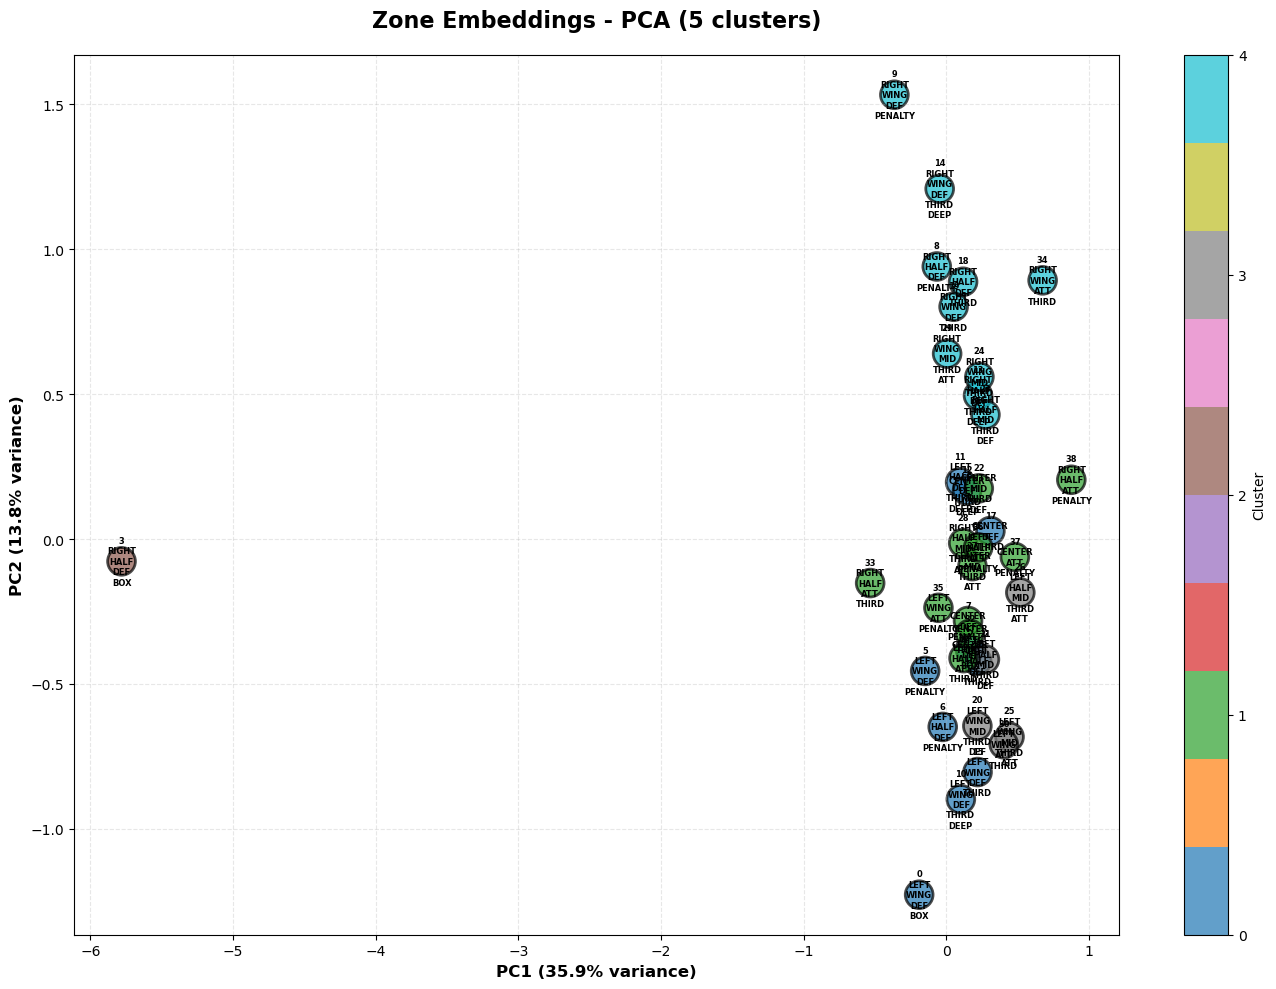

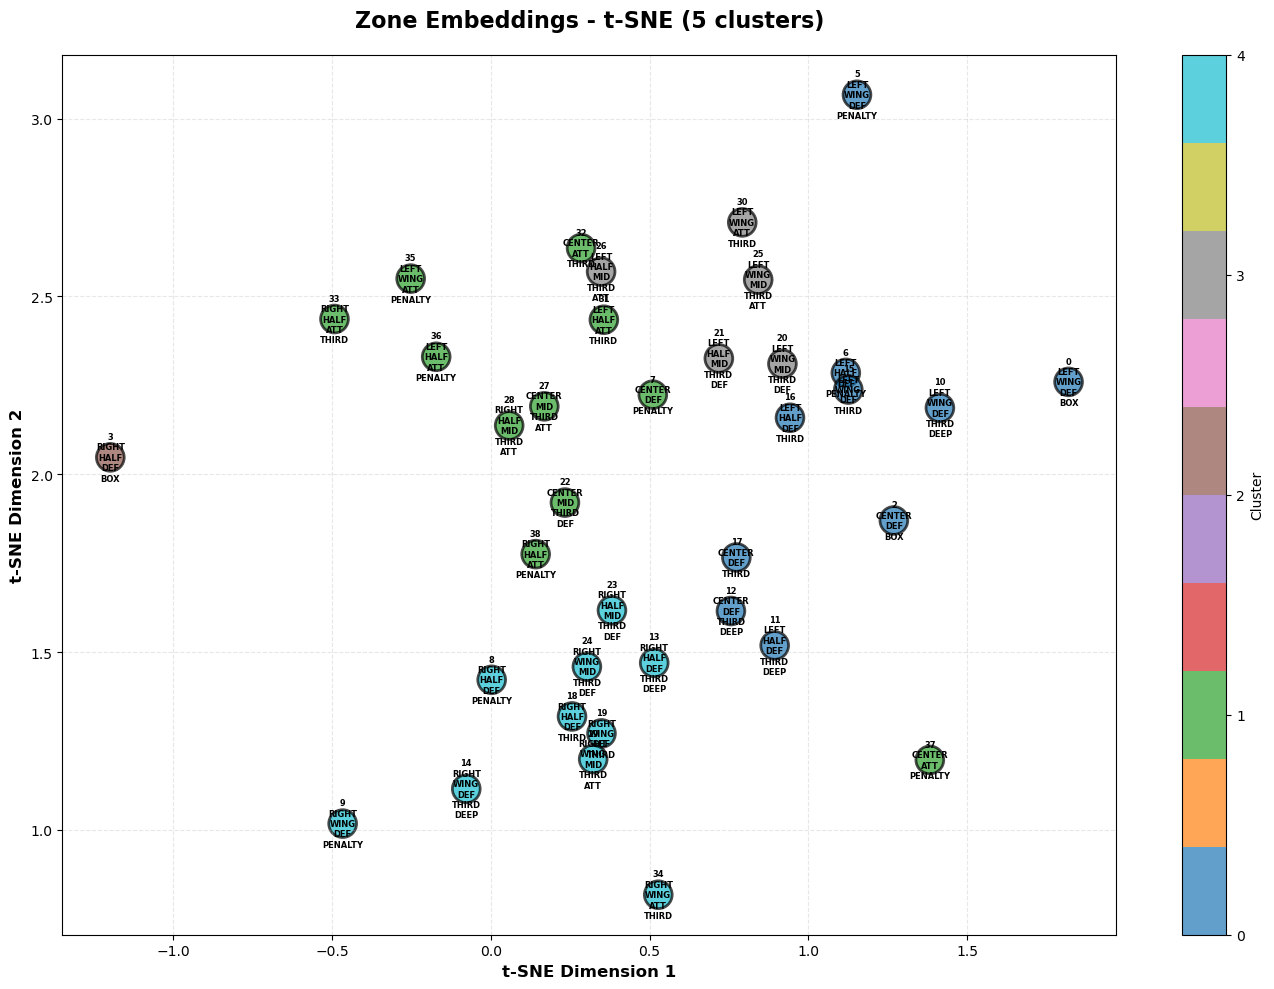

In [28]:
print("="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

# -------------------------
# 5.1: PCA 2D Visualization
# -------------------------

print("\n1. Creating PCA visualization...")

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

fig1, ax1 = plt.subplots(figsize=(14, 10))

# Plot points colored by cluster
colors = [zone_clusters[node] for node in nodes]
scatter = ax1.scatter(X_2d[:, 0], X_2d[:, 1], 
                     c=colors, 
                     cmap='tab10', 
                     s=400, 
                     alpha=0.7, 
                     edgecolors='black', 
                     linewidth=2)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax1, label='Cluster')
cbar.set_ticks(range(n_clusters))

# Add zone labels
for i, node in enumerate(nodes):
    zone_name = zt.get_zone_name(node).replace('_', '\n')
    ax1.annotate(f"{node}\n{zone_name}", 
                (X_2d[i, 0], X_2d[i, 1]), 
                fontsize=6, 
                ha='center', 
                va='center',
                fontweight='bold')

ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', 
              fontsize=12, fontweight='bold')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', 
              fontsize=12, fontweight='bold')
ax1.set_title(f'Zone Embeddings - PCA ({n_clusters} clusters)', 
             fontsize=16, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('zone_embeddings_pca.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: zone_embeddings_pca.png")

# -------------------------
# 5.2: t-SNE Visualization
# -------------------------

print("\n2. Creating t-SNE visualization...")

tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(nodes)-1))
X_tsne = tsne.fit_transform(X)

fig2, ax2 = plt.subplots(figsize=(14, 10))

scatter2 = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], 
                      c=colors, 
                      cmap='tab10', 
                      s=400, 
                      alpha=0.7, 
                      edgecolors='black', 
                      linewidth=2)

cbar2 = plt.colorbar(scatter2, ax=ax2, label='Cluster')
cbar2.set_ticks(range(n_clusters))

for i, node in enumerate(nodes):
    zone_name = zt.get_zone_name(node).replace('_', '\n')
    ax2.annotate(f"{node}\n{zone_name}", 
                (X_tsne[i, 0], X_tsne[i, 1]), 
                fontsize=6, 
                ha='center', 
                va='center',
                fontweight='bold')

ax2.set_xlabel('t-SNE Dimension 1', fontsize=12, fontweight='bold')
ax2.set_ylabel('t-SNE Dimension 2', fontsize=12, fontweight='bold')
ax2.set_title(f'Zone Embeddings - t-SNE ({n_clusters} clusters)', 
             fontsize=16, fontweight='bold', pad=20)
ax2.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('zone_embeddings_tsne.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: zone_embeddings_tsne.png")


3. Creating cluster characteristics plot...
   ✓ Saved: cluster_characteristics.png

4. Creating pitch visualization with clusters...
   ✓ Saved: zone_clusters_pitch.png

SAVING RESULTS
✓ Saved embeddings: zone_embeddings.npy
✓ Saved cluster labels: zone_clusters.csv
✓ Saved cluster analysis: cluster_analysis.csv

✓ COMPLETE! All visualizations and results saved.


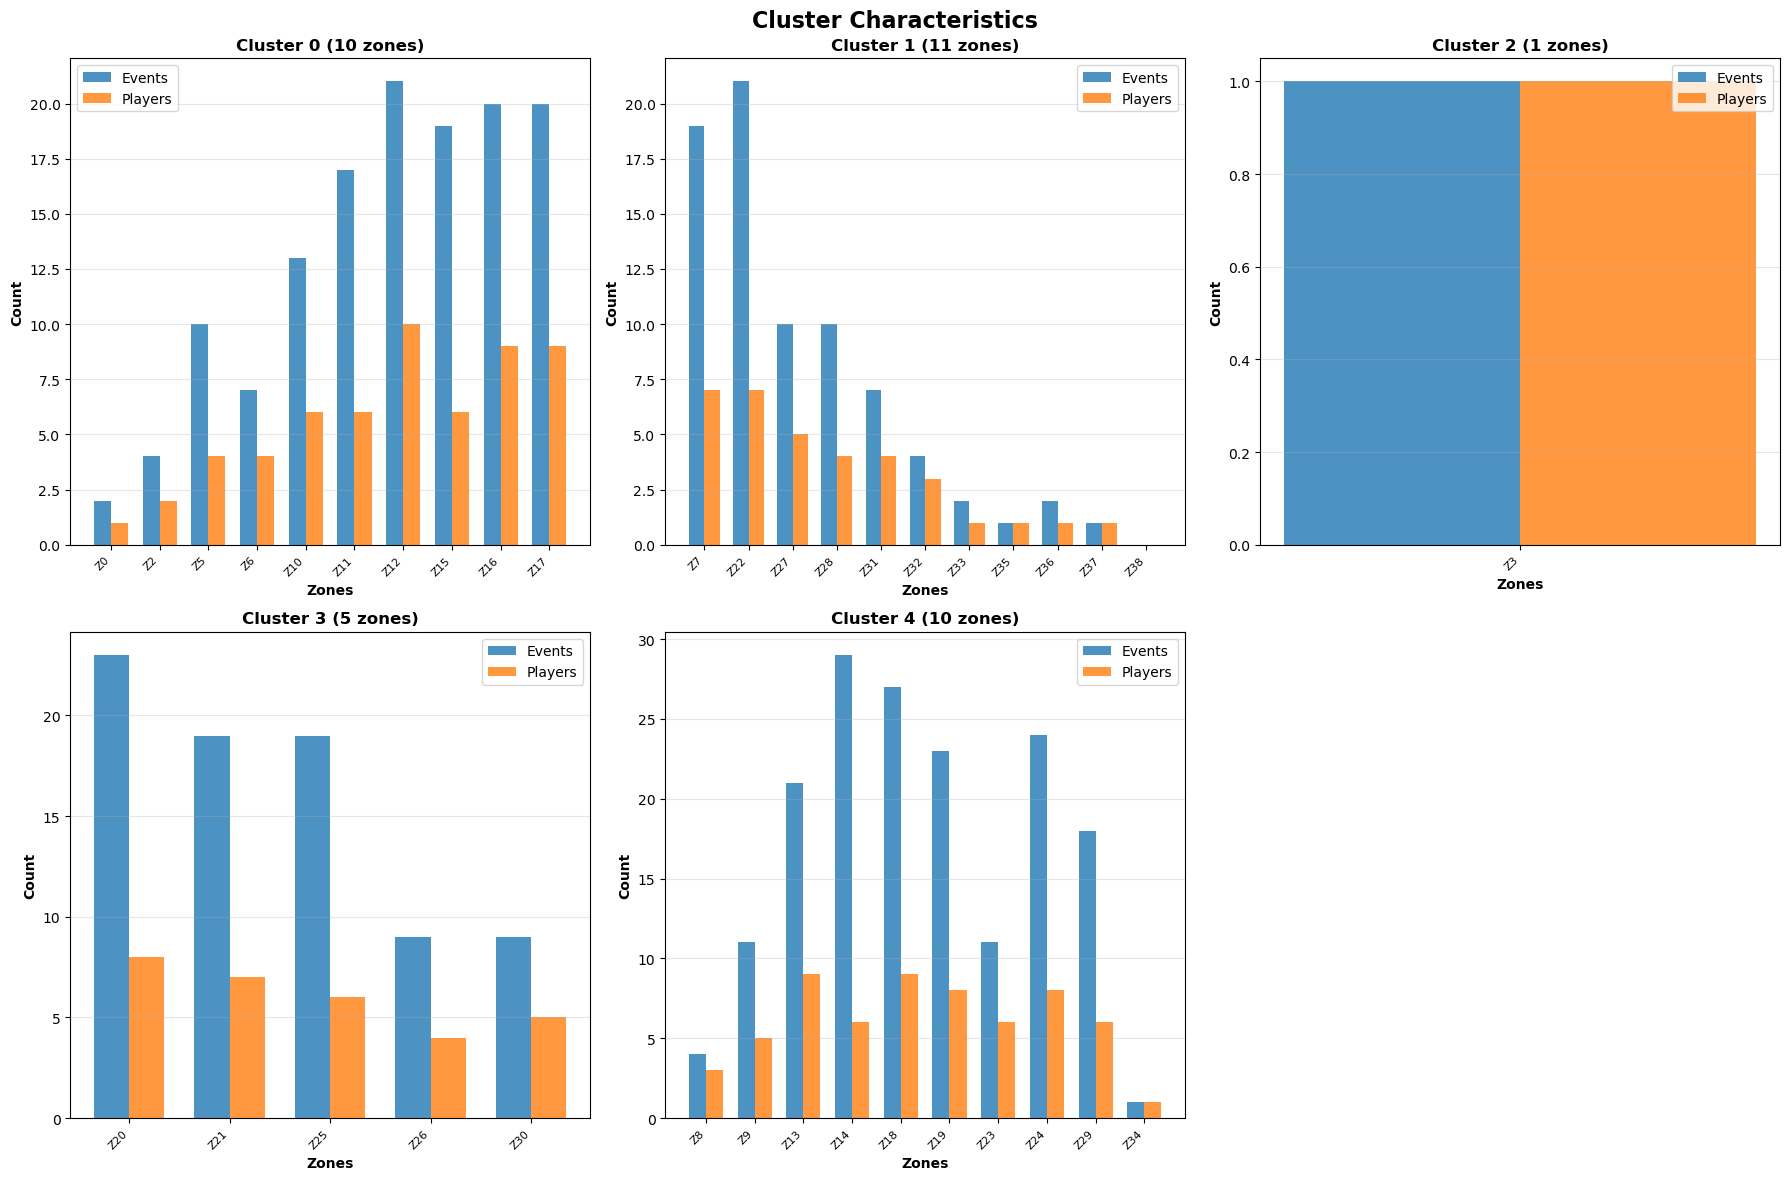

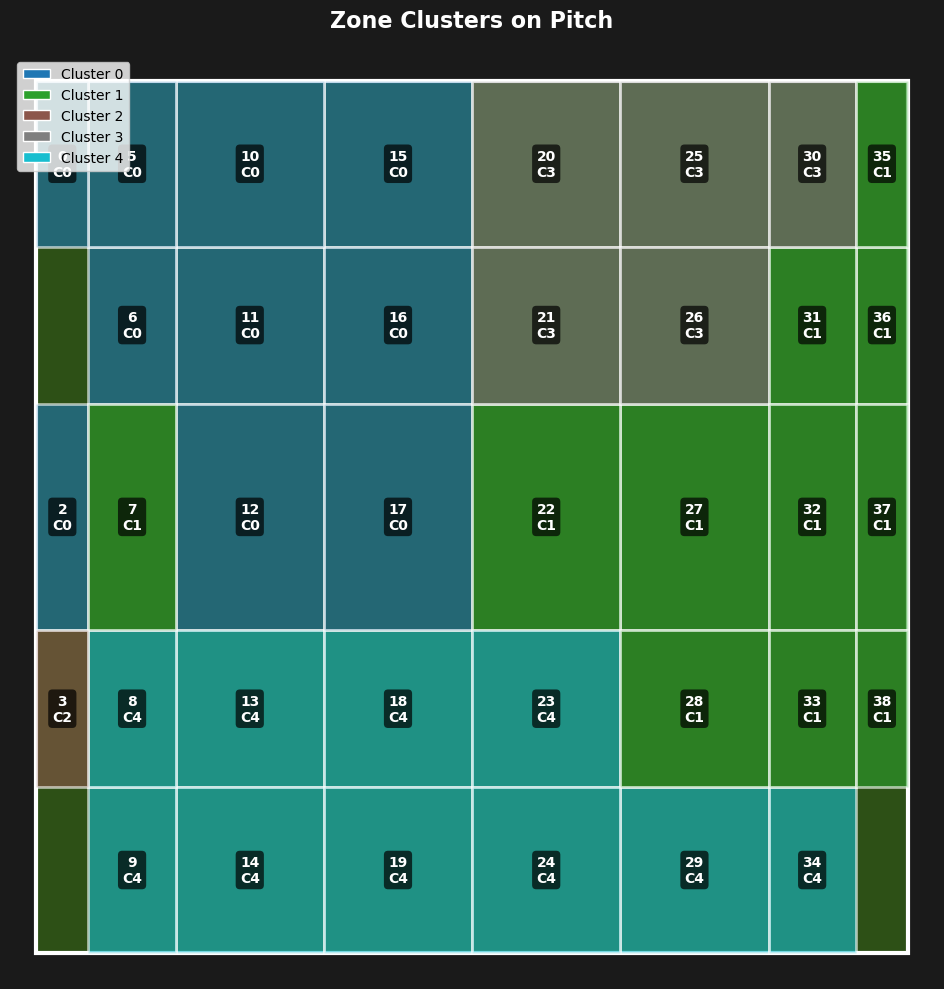

In [29]:

# -------------------------
# 5.3: Cluster Characteristics
# -------------------------

print("\n3. Creating cluster characteristics plot...")

fig3, axes = plt.subplots(2, 3, figsize=(18, 12))
fig3.suptitle('Cluster Characteristics', fontsize=16, fontweight='bold')

for cluster_id in range(n_clusters):
    ax = axes[cluster_id // 3, cluster_id % 3]
    
    zones_in_cluster = [z for z, l in zone_clusters.items() if l == cluster_id]
    
    # Collect statistics
    event_counts = []
    player_counts = []
    zone_names = []
    
    for zone in sorted(zones_in_cluster):
        if zone in G_home.nodes():
            event_counts.append(G_home.nodes[zone].get('event_count', 0))
            player_counts.append(G_home.nodes[zone].get('unique_players', 0))
            zone_names.append(f"Z{zone}")
    
    if event_counts:
        x = np.arange(len(zones_in_cluster))
        width = 0.35
        
        ax.bar(x - width/2, event_counts, width, label='Events', alpha=0.8)
        ax.bar(x + width/2, player_counts, width, label='Players', alpha=0.8)
        
        ax.set_xlabel('Zones', fontweight='bold')
        ax.set_ylabel('Count', fontweight='bold')
        ax.set_title(f'Cluster {cluster_id} ({len(zones_in_cluster)} zones)', 
                    fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(zone_names, rotation=45, ha='right', fontsize=8)
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', 
               transform=ax.transAxes, fontsize=12)
        ax.set_title(f'Cluster {cluster_id} (empty)', fontweight='bold')

# Hide the 6th subplot if we only have 5 clusters
if n_clusters < 6:
    axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('cluster_characteristics.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: cluster_characteristics.png")

# -------------------------
# 5.4: Cluster Distribution on Pitch
# -------------------------

print("\n4. Creating pitch visualization with clusters...")

from matplotlib import patches

fig4, ax4 = plt.subplots(figsize=(14, 10), facecolor='#1a1a1a')
ax4.set_facecolor('#2d5016')

# Draw pitch outline
pitch_rect = patches.Rectangle(
    (0, 0), 100, 100,
    linewidth=3, edgecolor='white', facecolor='#2d5016', zorder=1
)
ax4.add_patch(pitch_rect)

# Draw zones with cluster colors
cluster_colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))

for node in G_home.nodes():
    x_min, x_max, y_min, y_max = zt.get_zone_bounds(node)
    cluster = zone_clusters[node]
    
    zone_rect = patches.Rectangle(
        (x_min, y_min),
        x_max - x_min,
        y_max - y_min,
        linewidth=2,
        edgecolor='white',
        facecolor=cluster_colors[cluster],
        alpha=0.6,
        zorder=2
    )
    ax4.add_patch(zone_rect)
    
    # Add zone ID and cluster
    x_center, y_center = zt.get_zone_center(node)
    ax4.text(x_center, y_center, f"{node}\nC{cluster}",
            ha='center', va='center',
            fontsize=10, fontweight='bold', color='white',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='black', 
                     alpha=0.7, edgecolor='none'),
            zorder=3)

# Add legend
legend_elements = [patches.Patch(facecolor=cluster_colors[i], 
                                edgecolor='white', 
                                label=f'Cluster {i}')
                  for i in range(n_clusters)]
ax4.legend(handles=legend_elements, loc='upper left', fontsize=10)

ax4.set_xlim(-3, 103)
ax4.set_ylim(-3, 103)
ax4.set_aspect('equal')
ax4.axis('off')
ax4.set_title('Zone Clusters on Pitch', fontsize=16, color='white', 
             fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('zone_clusters_pitch.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: zone_clusters_pitch.png")

# ============================================================================
# 6. SAVE RESULTS
# ============================================================================

print("\n" + "="*70)
print("SAVING RESULTS")
print("="*70)

# Save embeddings
np.save('zone_embeddings.npy', embeddings)
print("✓ Saved embeddings: zone_embeddings.npy")

# Save cluster labels
pd.DataFrame({
    'zone_id': list(zone_clusters.keys()),
    'cluster': list(zone_clusters.values())
}).to_csv('zone_clusters.csv', index=False)
print("✓ Saved cluster labels: zone_clusters.csv")

# Save detailed cluster analysis
cluster_analysis = []
for node in sorted(embeddings.keys()):
    if node in G_home.nodes():
        cluster_analysis.append({
            'zone_id': node,
            'zone_name': zt.get_zone_name(node),
            'cluster': zone_clusters[node],
            'event_count': G_home.nodes[node].get('event_count', 0),
            'unique_players': G_home.nodes[node].get('unique_players', 0),
            'most_common_event': G_home.nodes[node].get('most_common_event', 'N/A')
        })

df_clusters = pd.DataFrame(cluster_analysis)
df_clusters.to_csv('cluster_analysis.csv', index=False)
print("✓ Saved cluster analysis: cluster_analysis.csv")

print("\n" + "="*70)
print("✓ COMPLETE! All visualizations and results saved.")
print("="*70)

plt.show()